In [4]:
#분석 라이브러리 설치
import numpy as np
import pandas as pd

In [6]:
#입력 데이터 파일보기
import os
for dirname,  _, filenames in os.walk('kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

kaggle/input\american_sign_language.png
kaggle/input\amer_sign2.png
kaggle/input\amer_sign3.png
kaggle/input\memo.txt
kaggle/input\sign_mnist_test.csv
kaggle/input\sign_mnist_train.csv


In [8]:
#TensorFlow backend 사용
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

In [15]:
#ASL dataset 로드
train_df = pd.read_csv("kaggle/input/sign_mnist_train.csv")
test_df = pd.read_csv("kaggle/input/sign_mnist_test.csv")

In [16]:
test=pd.read_csv("kaggle/input/sign_mnist_test.csv")
y = test['label']

In [82]:
train_df.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,107,118,127,134,139,143,146,150,153,156,...,207,207,207,207,206,206,206,204,203,202
1,155,157,156,156,156,157,156,158,158,157,...,69,149,128,87,94,163,175,103,135,149
2,187,188,188,187,187,186,187,188,187,186,...,202,201,200,199,198,199,198,195,194,195
3,211,211,212,212,211,210,211,210,210,211,...,235,234,233,231,230,226,225,222,229,163
4,164,167,170,172,176,179,180,184,185,186,...,92,105,105,108,133,163,157,163,164,179


C:\Users\Ga Young\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

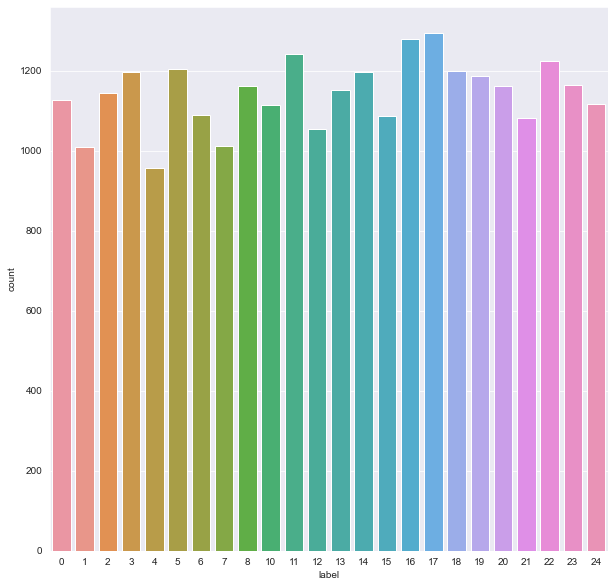

In [18]:
#데이터 시각화 및 사전 처리
#그래프를 보면, label 9가 빠져있는걸 볼 수 있음. 
#A-Z(제스처 모션으로 인해 9=J 또는 25=Z의 경우는 없음)
plt.figure(figsize = (10,10)) # Label Count
sns.set_style("darkgrid")
sns.countplot(train_df['label'])

In [19]:
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

In [20]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [21]:
x_train = train_df.values
x_test = test_df.values

In [22]:
#조명 차이의 영향을 줄이기 위해 그레이스케일 정규화를 수행
#더욱이 CNN은 [0.1] 데이터보다 [0.255] 데이터 상에서 더 빠르게 수렴

# 데이터정규화
x_train = x_train / 255
x_test = x_test / 255

In [23]:
# CNN의 입력을 통해 필요한 데이터를 1-D에서 3-D로 재구성
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

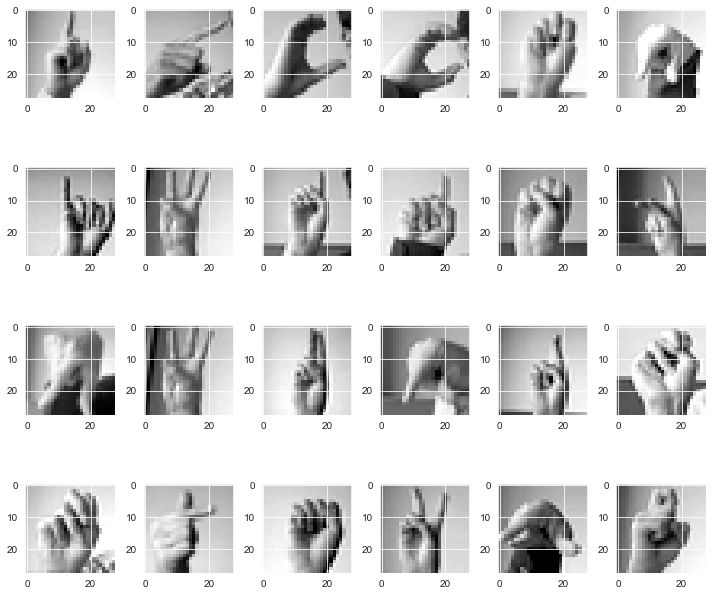

In [89]:
#모든 이미지 확인
f, ax = plt.subplots(4,6) 
f.set_size_inches(10, 10)
k = 0
for i in range(4):
    for j in range(6):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()

In [25]:
#데이터 Augmentation(=데이터 확대) -정규화 방법 중 하나
#과적합문제를 해결하기 위해 데이터를 인위적으로 확장하는 과정
#레이블을 동일하게 유지하면서 배열 표현을 변경하는 방법
#그레이스케일, 수평 플립, 수직 플립, 무작위 작물, 색 불안, 번역, 회전 등
datagen = ImageDataGenerator(
        featurewise_center=False,  #데이터 집합에 대해 입력 평균을 0으로 설정
        samplewise_center=False,  #각 표본 평균을 0으로 설정
        featurewise_std_normalization=False,  # 데이터 세트의 std로 입력을 나눔
        samplewise_std_normalization=False,  # 각각의 입력을 그 규격으로 나눔
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # 범위에서 랜덤하게 이미지 회전(0~180도)
        zoom_range = 0.1, # 랜덤 확대/축소 이미지
        width_shift_range=0.1,  #랜덤하게 이미지를 수평으로 이동(전체 폭의 크기)
        height_shift_range=0.1,  # 이미지를 수직으로 랜덤 이동(총 높이 기준)
        horizontal_flip=False,  # 이미지를 임의로 뒤집기
        vertical_flip=False)  # 이미지를 임의로 뒤집기

datagen.fit(x_train)

#일부 훈련 이미지를 10도 랜덤 확대/축소 10%씩 무작위로 회전
#일부 훈련 이미지를 랜덤으로 영상을 가로로 10% 이동
#수직_flip 또는 수평_flip을 적용하지 않은 이유는 잘못 분류될 수 있기 때문

In [92]:
x_train

array([[[[0.41960784],
         [0.4627451 ],
         [0.49803922],
         ...,
         [0.66666667],
         [0.66666667],
         [0.6627451 ]],

        [[0.43529412],
         [0.4745098 ],
         [0.50588235],
         ...,
         [0.67058824],
         [0.67058824],
         [0.66666667]],

        [[0.44313725],
         [0.48235294],
         [0.51372549],
         ...,
         [0.67058824],
         [0.67058824],
         [0.67058824]],

        ...,

        [[0.55686275],
         [0.58823529],
         [0.62352941],
         ...,
         [0.79215686],
         [0.78823529],
         [0.78431373]],

        [[0.55686275],
         [0.59215686],
         [0.62745098],
         ...,
         [0.8       ],
         [0.79607843],
         [0.79215686]],

        [[0.55686275],
         [0.59215686],
         [0.62745098],
         ...,
         [0.8       ],
         [0.79607843],
         [0.79215686]]],


       [[[0.60784314],
         [0.61568627],
         [0.61

In [26]:
#컨볼루션 신경망(Convolutional Neural Network) 구조
#컨볼루션 연산이라는 특수한 수학 행렬 조작을 사용하여 이미지에서 데이터를 처리하는 인공지능 구현의 특별한 유형
#두 행렬을 곱하고 세 번째 행렬, 더 작은 행렬을 낳음으로써 이것을 수행
#네트워크는 입력 이미지를 사용하고 필터(또는 커널)를 사용하여 이미지를 설명하는 기능 맵을 만듦
#컨볼루션 작업에서는 필터(일반적으로 2x2 또는 3x3 매트릭스)를 사용하여 이미지 매트릭스 위로 밀어넣는다. 
#두 행렬의 핵심 대응 숫자는 곱하여 그 입력 공간을 설명하는 하나의 숫자를 산출하기 위해 추가된다. 
#이 프로세스는 이미지 전체에서 반복 됨

In [27]:
#Training The Model
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [93]:
learning_rate_reduction

In [28]:
#from keras.models import Sequential
#from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization

model = Sequential()

model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))

model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 75)        750       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 75)        300       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 75)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 50)        33800     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 50)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 50)        200       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 50)          0

In [29]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 128) ,epochs = 20 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])

Epoch 1/20
215/215 [==============================] - 54s 170ms/step - loss: 1.8298 - accuracy: 0.4530 - val_loss: 3.4927 - val_accuracy: 0.1247
Epoch 2/20
215/215 [==============================] - 36s 167ms/step - loss: 0.2763 - accuracy: 0.9086 - val_loss: 1.1690 - val_accuracy: 0.6361
Epoch 3/20
215/215 [==============================] - 37s 174ms/step - loss: 0.1178 - accuracy: 0.9619 - val_loss: 0.2901 - val_accuracy: 0.9041
Epoch 4/20
215/215 [==============================] - 36s 167ms/step - loss: 0.0738 - accuracy: 0.9769 - val_loss: 1.5194 - val_accuracy: 0.6207
Epoch 5/20
215/215 [==============================] - 35s 163ms/step - loss: 0.0553 - accuracy: 0.9824 - val_loss: 0.3646 - val_accuracy: 0.8763

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/20
215/215 [==============================] - 36s 167ms/step - loss: 0.0313 - accuracy: 0.9906 - val_loss: 0.0277 - val_accuracy: 0.9922
Epoch 7/20
215/215 [=============================

In [30]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

225/225 [==============================] - 2s 8ms/step - loss: 0.0021 - accuracy: 1.0000
Accuracy of the model is -  100.0 %


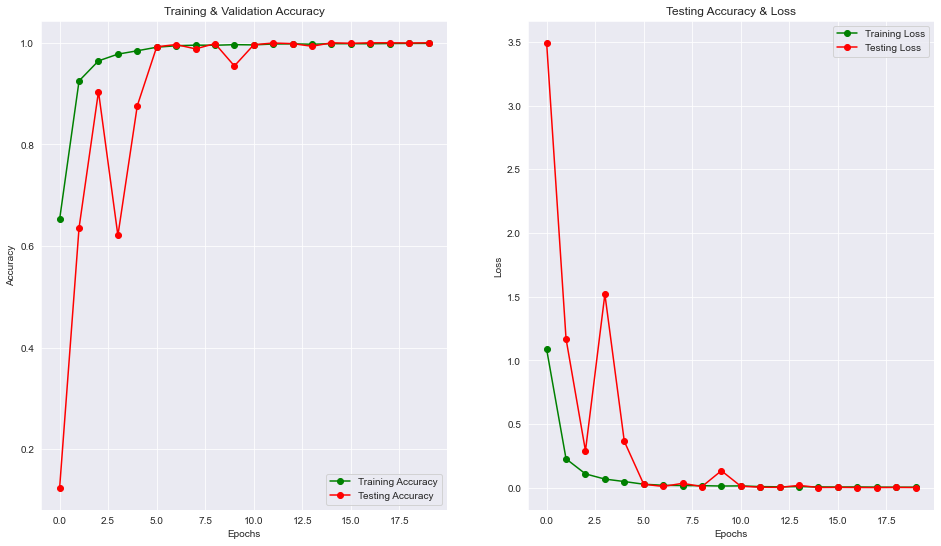

In [31]:
#Analysis after Model Training
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()


In [32]:
predictions = model.predict_classes(x_test)
for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1
predictions[:5]

C:\Users\Ga Young\anaconda3\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([ 6,  5, 10,  0,  3], dtype=int64)

In [33]:
classes = ["Class " + str(i) for i in range(25) if i != 9]
print(classification_report(y, predictions, target_names = classes))

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       331
     Class 1       1.00      1.00      1.00       432
     Class 2       1.00      1.00      1.00       310
     Class 3       1.00      1.00      1.00       245
     Class 4       1.00      1.00      1.00       498
     Class 5       1.00      1.00      1.00       247
     Class 6       1.00      1.00      1.00       348
     Class 7       1.00      1.00      1.00       436
     Class 8       1.00      1.00      1.00       288
    Class 10       1.00      1.00      1.00       331
    Class 11       1.00      1.00      1.00       209
    Class 12       1.00      1.00      1.00       394
    Class 13       1.00      1.00      1.00       291
    Class 14       1.00      1.00      1.00       246
    Class 15       1.00      1.00      1.00       347
    Class 16       1.00      1.00      1.00       164
    Class 17       1.00      1.00      1.00       144
    Class 18       1.00    

In [77]:
y

0        6
1        5
2       10
3        0
4        3
        ..
7167     1
7168    12
7169     2
7170     4
7171     2
Name: label, Length: 7172, dtype: int64

In [76]:
predictions

array([ 6,  5, 10, ...,  2,  4,  2], dtype=int64)

In [34]:
cm = confusion_matrix(y,predictions)

In [35]:
cm = pd.DataFrame(cm , index = [i for i in range(25) if i != 9] , columns = [i for i in range(25) if i != 9])

In [80]:
cm

,0,1,2,3,4,5,6,7,8,10,...,15,16,17,18,19,20,21,22,23,24
0,331,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,432,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,310,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,245,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,498,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,247,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,348,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,436,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,288,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,331,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

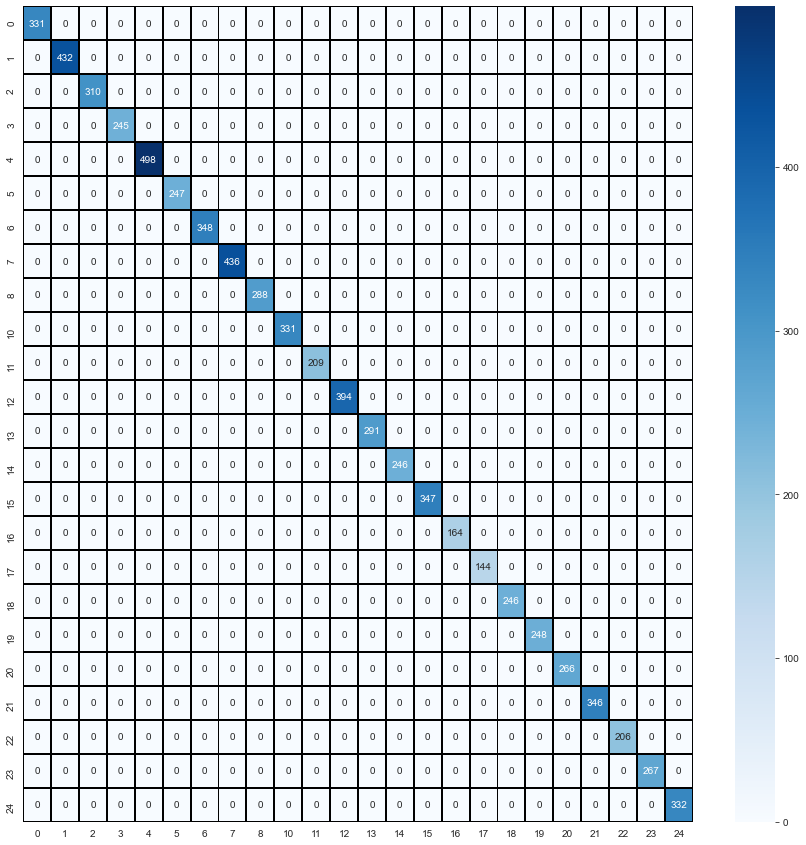

In [36]:
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [49]:
predictions==y

0       True
1       True
2       True
3       True
4       True
        ... 
7167    True
7168    True
7169    True
7170    True
7171    True
Name: label, Length: 7172, dtype: bool

In [53]:
np.array(predictions==y)

array([ True,  True,  True, ...,  True,  True,  True])

In [56]:
correct = np.nonzero(np.array(predictions==y))[0]

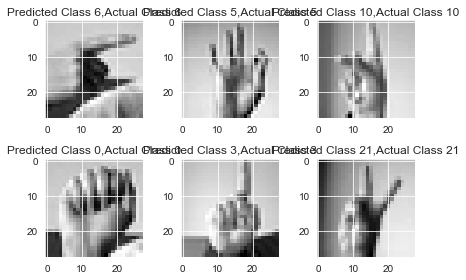

In [114]:
i = 0
for c in correct[:6]:
    plt.subplot(2,3,i+1)
    plt.imshow(x_test[c].reshape(28,28), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y[c]))
    plt.tight_layout()
    i += 1